<a href="https://colab.research.google.com/github/killercookiee/DeepM/blob/main/DeepM_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
!git clone https://github.com/AMIN-HASSAIRI/medical-image-segmentation.git

Cloning into 'medical-image-segmentation'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1094 (delta 0), reused 3 (delta 0), pack-reused 1089 (from 1)
Receiving objects: 100% (1094/1094), 2.24 GiB | 29.01 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (1051/1051), done.


Understanding the File format

Neuroimaging Informatics Technology Initiative
NIfTI is designed to handle 3D (volume) and 4D (time-series) data, which is common in brain imaging, especially for functional MRI (fMRI) studies
NIfTI files can also be stored in a compressed .nii.gz format to save disk space

4 D --> Height + Width + Depth + Time

We are working with pairs of files. Example
1. Say MRI scan of heart
2. Corresponding segmentation mask file -> i.e. a label that marks different part of the image, like heart chambers, valves, etc

Possibly

patient001_4d.nii.gz -> 4D file (Sequence of 3d images over time), not used for segmentation
patient001_frame01.nii.gz -> A single 2D slice of the 3D MRI data. Image file used for traning the model
patient001_frame01_gt.nii.gz -> It contains labels marking the regions of interest in the image

In [ ]:
# If the image file is patient_001_frame10.nii.gz, the corresponding segmentation file would be patient_001_frame10_gt.nii.gz. Check if both files exist
# If both files exist (MRI image and its segmentation mask), store them together in a list as a pair.

def select_training_data(dataset_dir):

    training_data_list = {}
    for k in ['training']:

        subset_dir = os.path.join(dataset_dir, k)
        training_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] == 't' and file[-21:-18]!='038' and file[-21:-18]!='057':

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        training_data_list[k] += [[image_name, segt_name, patient]]

    return training_data_list


In [ ]:
training_data_list = select_training_data("/content/medical-image-segmentation/dataset/")

In [ ]:
print(training_data_list)

{'training': [['/content/medical-image-segmentation/dataset/training/patient001/patient001_frame01.nii.gz', '/content/medical-image-segmentation/dataset/training/patient001/patient001_frame01_gt.nii.gz', 'patient001'], ['/content/medical-image-segmentation/dataset/training/patient001/patient001_frame12.nii.gz', '/content/medical-image-segmentation/dataset/training/patient001/patient001_frame12_gt.nii.gz', 'patient001'], ['/content/medical-image-segmentation/dataset/training/patient002/patient002_frame01.nii.gz', '/content/medical-image-segmentation/dataset/training/patient002/patient002_frame01_gt.nii.gz', 'patient002'], ['/content/medical-image-segmentation/dataset/training/patient002/patient002_frame12.nii.gz', '/content/medical-image-segmentation/dataset/training/patient002/patient002_frame12_gt.nii.gz', 'patient002'], ['/content/medical-image-segmentation/dataset/training/patient003/patient003_frame01.nii.gz', '/content/medical-image-segmentation/dataset/training/patient003/patient

DATA VISUALISATION

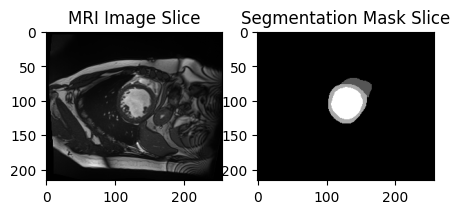

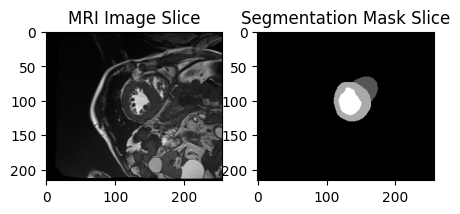

In [ ]:
## Visualising .nii.gz files using nibabel library ---- used for reading neuroimaging data

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

## Sample Example
example_data = training_data_list['training'][0]  # Get the first entry
image_path = example_data[0]  # Path to the image
mask_path = example_data[1]  # Path to the segmentation mask



def load_nifti_image(nifti_file):
    # Load the image using nibabel
    img = nib.load(nifti_file)
    img_data = img.get_fdata()  # Getting the actual image data as a numpy array
    return img_data

def visualize_image_and_mask(image_file, mask_file):
    # Load image and mask
    img_data = load_nifti_image(image_file)
    mask_data = load_nifti_image(mask_file)

    # Let's visualize a slice in the middle
    slice_num = img_data.shape[2] // 2
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))

    # Display MRI image slice
    ax[0].imshow(img_data[:, :, slice_num], cmap='gray')
    ax[0].set_title("MRI Image Slice")

    # Display Segmentation Mask slice
    ax[1].imshow(mask_data[:, :, slice_num], cmap='gray')
    ax[1].set_title("Segmentation Mask Slice")

    plt.show()

# Random examples visualisation

visualize_image_and_mask(training_data_list['training'][0][0], training_data_list['training'][0][1])
visualize_image_and_mask(training_data_list['training'][50][0], training_data_list['training'][50][1])


**DATA NORMALISATION**

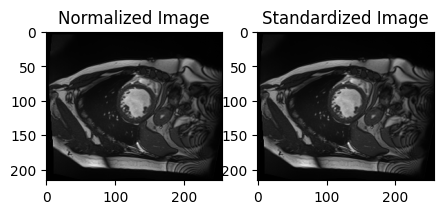

In [ ]:
## Try to normalise the pixel intensity values to a specific range , Neural Networks are sensitive to the scale of input data
## (pixel_val - min_pixel)/ (max_pixel - min_pixel)

def normalize_image(img_data): ##(Rescaling the raw pixels)

    img_min = np.min(img_data)
    img_max = np.max(img_data)
    normalized_img = (img_data - img_min) / (img_max - img_min)
    return normalized_img

## Just a random example traning[0][0]
normalized_img = normalize_image(load_nifti_image(training_data_list['training'][0][0]))

def standardize_image(img_data):
    # Standardize image (mean=0, std=1)
    mean = np.mean(img_data)
    std = np.std(img_data)
    standardized_img = (img_data - mean) / std
    return standardized_img

standardized_img = standardize_image(load_nifti_image(training_data_list['training'][0][0]))

slice_num = normalized_img.shape[2] // 2
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.imshow(normalized_img[:, :, slice_num], cmap='gray')
plt.title("Normalized Image")

plt.subplot(1, 2, 2)
plt.imshow(standardized_img[:, :, slice_num], cmap='gray')
plt.title("Standardized Image")

plt.show()



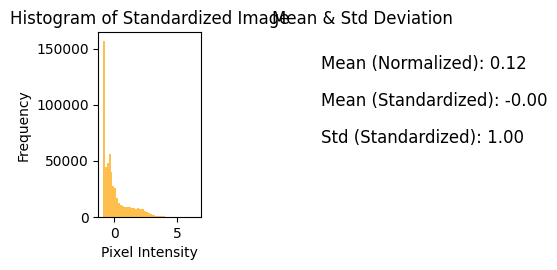

In [ ]:
# It is not uncommon to see noticeable difference

# Histogram for standardized image
plt.subplot(2, 3, 4)
plt.hist(standardized_img.ravel(), bins=50, color='orange', alpha=0.7)
plt.title("Histogram of Standardized Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Display means and standard deviations
mean_normalized = np.mean(normalized_img)
mean_standardized = np.mean(standardized_img)
std_standardized = np.std(standardized_img)

plt.subplot(2, 3, 5)
plt.text(0.1, 0.8, f'Mean (Normalized): {mean_normalized:.2f}', fontsize=12)
plt.text(0.1, 0.6, f'Mean (Standardized): {mean_standardized:.2f}', fontsize=12)
plt.text(0.1, 0.4, f'Std (Standardized): {std_standardized:.2f}', fontsize=12)
plt.axis('off')
plt.title("Mean & Std Deviation")

plt.tight_layout()
plt.show()

In [ ]:
def select_testing_data(dataset_dir):

    testing_data_list = {}
    for k in ['testing']:
        subset_dir = os.path.join(dataset_dir, k)
        testing_data_list[k] = []

        for data in sorted(os.listdir(subset_dir)):

            data_dir = os.path.join(subset_dir, data)

            for fr in sorted(os.listdir(data_dir)):
                if fr[-8] != 'd' and fr[-8] != 'I':

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(data_dir, data, fr[-9:-7])

                    if os.path.exists(image_name):
                        testing_data_list[k] += [image_name]

    return testing_data_list

In [ ]:
testing_data_list = select_testing_data("/content/medical-image-segmentation/dataset/")

In [ ]:
print(testing_data_list)

{'testing': ['/content/medical-image-segmentation/dataset/testing/patient101/patient101_frame01.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient101/patient101_frame14.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient102/patient102_frame01.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient102/patient102_frame13.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient103/patient103_frame01.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient103/patient103_frame11.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient104/patient104_frame01.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient104/patient104_frame11.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient105/patient105_frame01.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient105/patient105_frame10.nii.gz', '/content/medical-image-segmentation/dataset/testing/patient106/pat